>>> Loading entire TIFF (3D)...
>>> Global normalization...
>>> Applying global CLAHE...
>>> Wavelet denoise (BayesShrink, soft)...
>>> Median filtering per slice...
>>> Adaptive percentile stretch...
✅ Saved processed image: /Users/joeyroberts/Desktop/Spines/Processed/processed_3D_base.tif


/var/folders/gt/ms6k8rtn2s5cxz9b6gypxgd40000gn/T/ipykernel_60861/1885331079.py:80: UserWarning: /Users/joeyroberts/Desktop/Spines/Processed/processed_3D_base.tif is a low contrast image
  imsave(save_path, final)


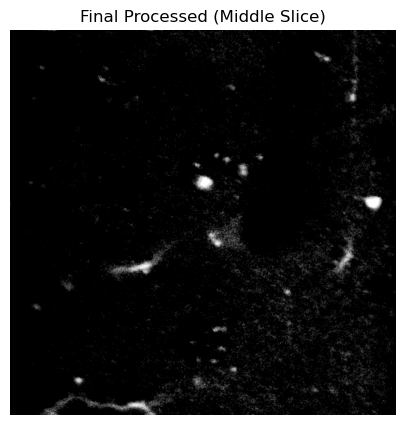

🎉 Preprocessing completed successfully!


In [ ]:
# Ran this on the selfnet data and then put it in the test script

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage import exposure
from skimage.restoration import denoise_wavelet
from skimage.filters import median

# ===============================
# INPUT FILE PATH
# ===============================
image_path = "/Users/joeyroberts/Downloads/F13_2_20250323_roi1_Red_shifted.tif"
assert os.path.exists(image_path), f"File not found: {image_path}"

print(">>> Loading entire TIFF (3D)...")
image = imread(image_path)  # Expect shape (Z, Y, X)
assert image.ndim == 3, f"Expected 3D TIFF. Got shape: {image.shape}"

# ===============================
# GLOBAL NORMALIZATION
# ===============================
print(">>> Global normalization...")
vmin = np.percentile(image, 0.5)
vmax = np.percentile(image, 99.5)
image_norm = np.clip((image - vmin) / (vmax - vmin), 0, 1)

# Convert to 12-bit range for processing stability
image_uint = (image_norm * 1024).astype(np.uint16)

# ===============================
# GLOBAL CLAHE (gentle)
# ===============================
print(">>> Applying global CLAHE...")
image_clahe = exposure.equalize_adapthist(
    image_uint, 
    clip_limit=0.005  # ↓ keep noise controlled
)

# ===============================
# WAVELET DENOISING
# ===============================
print(">>> Wavelet denoise (BayesShrink, soft)...")
denoised = denoise_wavelet(
    image_clahe,
    channel_axis=None,
    method='BayesShrink',
    mode='soft',
    wavelet='db2',
    rescale_sigma=True
)

# ===============================
# MEDIAN SMOOTHING
# ===============================
print(">>> Median filtering per slice...")
denoised = (denoised * 1024).astype(np.uint16)
filtered = np.array([
    median(denoised[z], footprint=np.ones((3,3)))  # 3x3 smoothing
    for z in range(denoised.shape[0])
])

# ===============================
# ROBUST PERCENTILE CONTRAST STRETCH
# (less aggressive → preserves faint signals)
# ===============================
print(">>> Adaptive percentile stretch...")
low = np.percentile(filtered, 78)     # tuneable
high = np.percentile(filtered, 99.9)  # tuneable

final = np.clip((filtered - low) / (high - low), 0, 1)
final = (final * 4095).astype(np.uint16)  # convert to 12-bit TIFF depth

# ===============================
# SAVE RESULTS
# ===============================
save_dir = "/Users/joeyroberts/Desktop/Spines/Processed"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "processed_3D_base.tif")
imsave(save_path, final)
print(f"✅ Saved processed image: {save_path}")

# ===============================
# QUICK VISUAL CHECK (middle slice)
# ===============================
mid = final.shape[0] // 2
plt.figure(figsize=(10,5))
plt.title("Final Processed (Middle Slice)")
plt.imshow(final[mid], cmap="gray")
plt.axis("off")
plt.show()

print("🎉 Preprocessing completed successfully!")
